In [1]:
%pylab inline
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print("TensorFlow Probability version:", tfp.__version__)

Populating the interactive namespace from numpy and matplotlib
TensorFlow version: 2.5.0
TensorFlow Probability version: 0.13.0


In [2]:
import edward2 as ed

from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

In [3]:
# A few hyper parameters
temperature=0.02
batch_size=1
box_size = 250
mesh_size = 128
include_cen = True
include_sat = False
max_sat_low = 64
max_sat_high = 500

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

Total size of halo catalog 195126
Size of low mass halo catalog 193574
Size of high mass halo catalog 1552


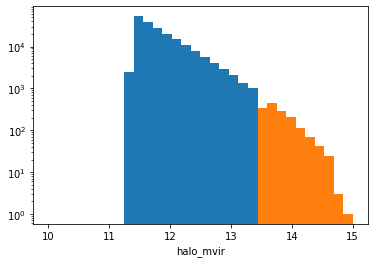

In [4]:
# choosing subvolume so we can play around easier with derivatives

# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
halo_table = halo_table[np.log10(halo_table['halo_mvir']) > 11.4] # Removing halos of too low mass
halocat._halo_table = halo_table
print("Total size of halo catalog", len(halo_table))

# Split the catalog into low and high mass halo
low_mass_table = halo_table[np.log10(halo_table['halo_mvir']) < 13.5]
high_mass_table = halo_table[np.log10(halo_table['halo_mvir']) >= 13.5]

# Convert table to tensors
tf_halocat_low = {k: tf.convert_to_tensor(low_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}
tf_halocat_high = {k: tf.convert_to_tensor(high_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}

hist(log10(low_mass_table['halo_mvir']),32, range=[10,15]);
hist(log10(high_mass_table['halo_mvir']),32, range=[10,15]);
yscale('log')
xlabel('halo_mvir');
print("Size of low mass halo catalog", len(low_mass_table))
print("Size of high mass halo catalog", len(high_mass_table));

In [5]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =0, 
                                        modulate_with_cenocc=True)

def hod(halo_cat, logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
        max_sat=20, name='hod'):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature,
                      name=name+'_cen')
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature,
                      name=name+'_sat')
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = tf.stack([halo_cat['halo_x'],
                      halo_cat['halo_y'],
                      halo_cat['halo_z']], axis=-1)

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat,),
                       name=name+'_sat_pos')
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [6]:
# sampling galaxies from the model with dhod
gal_cat_low = hod(tf_halocat_low, max_sat=max_sat_low)
gal_cat_high = hod(tf_halocat_high, max_sat=max_sat_high)

In [7]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

# Extracting halotools galaxies in similar format to DHOD
def refactor(galaxy_table):
    centrals = zheng07_model.mock.galaxy_table['gal_type'] == 'centrals'
    
    pos = return_xyz_formatted_array(galaxy_table['x'],
                                     galaxy_table['y'],
                                     galaxy_table['z'])
    pos_cen = pos[centrals]
    pos_sat = pos[~centrals]
    
    return {'pos_cen': tf.convert_to_tensor(pos_cen), 
            'pos_sat': tf.convert_to_tensor(pos_sat), 
            'n_cen': 1.,
            'n_sat': 1.}

ht_cat = refactor(zheng07_model.mock.galaxy_table)

In [8]:
def paint_galaxies(gal_cat, nc=mesh_size, rho=None, include_sat=include_sat, include_cen=include_cen):
  """ Function that paints galaxies on the field
  """
  # Take centrals and rescale them to the boxsize
  bs = 1 #gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  if rho is None:
    rho = tf.zeros((bs, nc, nc, nc))

  if include_cen:
      rho = cic_paint(rho, sample1_r, weights1)
  if include_sat:
      rho = cic_paint(rho, sample2, weights2)
  return rho

In [9]:
rho_dhod = paint_galaxies(gal_cat_low)
rho_dhod = paint_galaxies(gal_cat_high, rho=rho_dhod)

In [10]:
rho_ht = paint_galaxies(ht_cat)

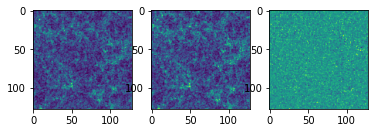

In [11]:
subplot(131)
imshow(rho_dhod[0].numpy().sum(axis=0))
subplot(132)
imshow(rho_ht[0].numpy().sum(axis=0))
subplot(133)
imshow(rho_ht[0].numpy().sum(axis=0) - rho_dhod[0].numpy().sum(axis=0))

In [12]:
# Let's now build a function that returns a sampled power spectrum
kf = 2.*np.pi/box_size 
PS = Power_Spectrum(shape=np.array([mesh_size, mesh_size, mesh_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=kf,dk=kf)

def get_pk(cat_low, cat_high=None):
  """ This function samples the catalogs, paint the galaxies, and compute the 
  power spectrum
  """
  # Sample and paint galaxies low mass halos
  rho = paint_galaxies(cat_low)

  if cat_high is not None:
    rho = paint_galaxies(cat_high, rho=rho)
  
  # Compute power spectrum of resulting field
  k, pk = PS.pk_tf(rho)
  return k, pk

In [13]:
k, pk_dhod = get_pk(cat_low=gal_cat_low, cat_high=gal_cat_high)
k, pk_ht = get_pk(ht_cat)

Instructions for updating:
Use fn_output_signature instead


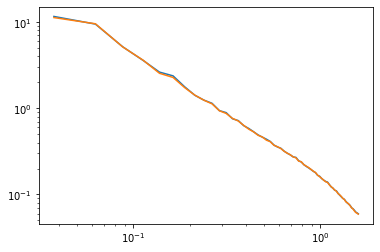

In [14]:
loglog(k, pk_ht[0])
loglog(k, pk_dhod[0])

In [15]:
# Let's run a few samplings and compare
@tf.function
def tf_sampling():
    gal_cat_low = hod(tf_halocat_low, max_sat=max_sat_low)
    gal_cat_high = hod(tf_halocat_high, max_sat=max_sat_high)
        
    k, pk_dhod = get_pk(cat_low=gal_cat_low, cat_high=gal_cat_high)
    
    return pk_dhod

In [16]:
# Unfortunately because catalogs will have different sizes we can't tf compile the pk function
def ht_sampling():
    zheng07_model.populate_mock(halocat) 
    ht_cat = refactor(zheng07_model.mock.galaxy_table)
    _, pk = get_pk(ht_cat)
    return pk

In [17]:
%timeit tf_sampling()

12.2 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit ht_sampling()

488 ms ± 7.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
# This can take about 10 mins
ht_pks = np.concatenate([ht_sampling() for i in range(100)],axis=0)

In [20]:
# This should only take a couple of mins
tf_pks = np.concatenate([tf_sampling() for i in range(100)],axis=0)

Text(0.5, 1.0, 'Mean')

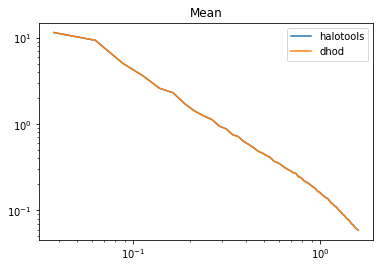

In [22]:
loglog(k, ht_pks.mean(axis=0),label='halotools')
loglog(k, tf_pks.mean(axis=0),label='dhod')
legend()
title('Mean')

Text(0.5, 1.0, 'Standard Deviation')

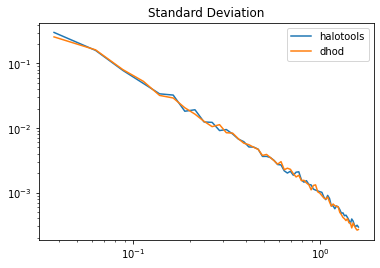

In [23]:
loglog(k, ht_pks.std(axis=0),label='halotools')
loglog(k, tf_pks.std(axis=0),label='dhod')
legend()
title('Standard Deviation')

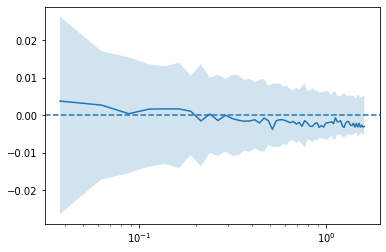

In [27]:
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0)) / ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)
axhline(0, ls='--')

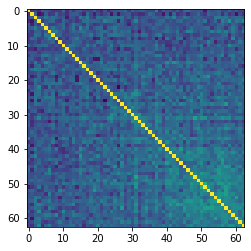

In [50]:
imshow(np.corrcoef(ht_pks.T))

## Below are the results of some experiments

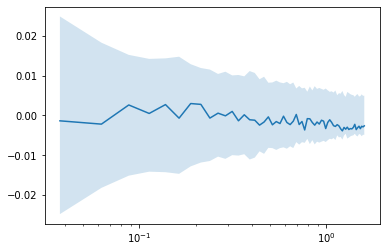

In [48]:
# This is just the centrals at temperature 0.02:
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0)) / ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

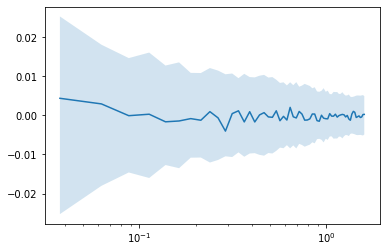

In [27]:
# This is just the centrals at temperature 0.001:
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0)) / ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

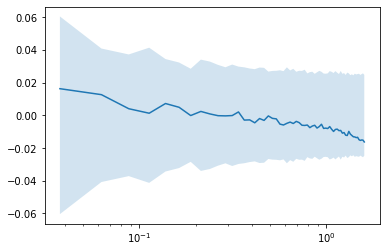

In [79]:
# This is just the satellites:
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0)) / ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

In [ ]:
# This is just the centrals at temperature 0.05:

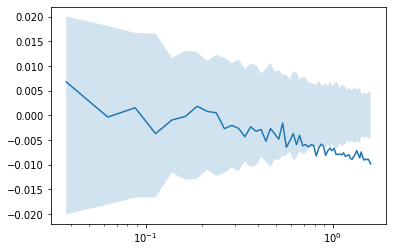

In [63]:
# This is with 64 sats for the low mass halos, 500 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0)) / ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

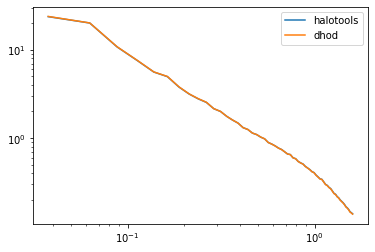

In [45]:
loglog(k, ht_pks.mean(axis=0),label='halotools')
loglog(k, tf_pks.mean(axis=0),label='dhod')
legend()

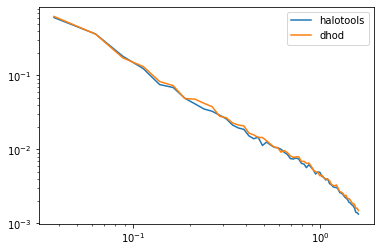

In [46]:
loglog(k, ht_pks.std(axis=0),label='halotools')
loglog(k, tf_pks.std(axis=0),label='dhod')
legend()

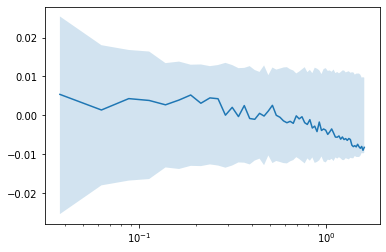

In [47]:
# This is with 64 sats for the low mass halos, 500 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0)) / ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

In [ ]:
# Below are tests where the catalogs are not 100% identical

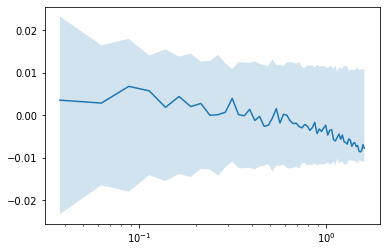

In [67]:
# This is with 64 sats for the low mass halos, 500 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0))/ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

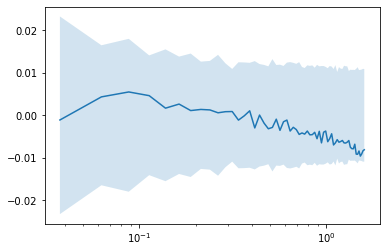

In [62]:
# This is with 30 sats for the low mass halos, 500 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0))/ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

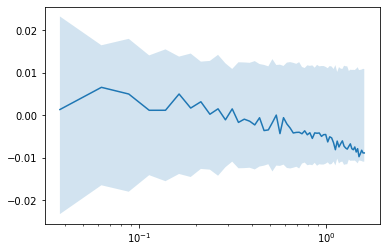

In [57]:
# This is with 30 sats for the low mass halos, 200 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0))/ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

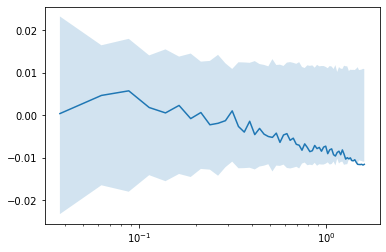

In [52]:
# This is with 30 sats for the low mass halos, 100 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0))/ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

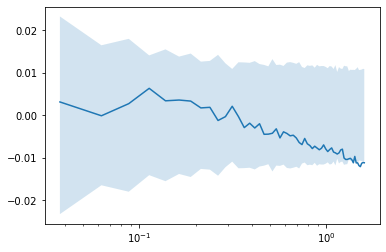

In [37]:
# This is with 20 sats for the low mass halos, 100 for high mass halos
semilogx(k, (tf_pks.mean(axis=0) - ht_pks.mean(axis=0))/ht_pks.mean(axis=0))
fill_between(k, -ht_pks.std(axis=0)/ht_pks.mean(axis=0), ht_pks.std(axis=0)/ht_pks.mean(axis=0), alpha=0.2)

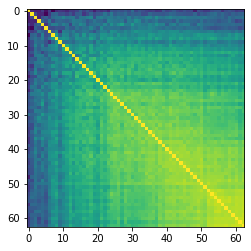

In [41]:
imshow(np.corrcoef(ht_pks.T))

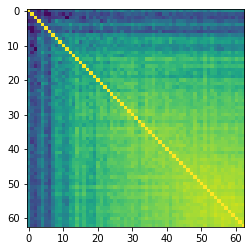

In [42]:
imshow(np.corrcoef(tf_pks.T))

In [6]:
bs = 128
#DHOD selected
sample1 = gal_cat['pos_cen']/128*bs
sample1_r = tf.tile(tf.expand_dims(sample1,0),[1,1,1])

sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3])/128*bs
sample2_r = tf.tile(tf.expand_dims(sample2,0),[1,1,1])

#HOD selected

# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001

#cutting same subvolume
ht_cens = ht_sample[m]
ht_cens = ht_cens[ht_cens[:,0]<128] 
ht_cens = ht_cens[ht_cens[:,1]<128] 
ht_cens = ht_cens[ht_cens[:,2]<128] 

ht_sats = ht_sample[~m]
ht_sats = ht_sats[ht_sats[:,0]<128] 
ht_sats = ht_sats[ht_sats[:,1]<128] 
ht_sats = ht_sats[ht_sats[:,2]<128] 

#DHOD painted
painted_central_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample1_r,weight=gal_cat['n_cen'])
painted_sat_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample2_r,weight=tf.reshape(gal_cat['n_sat'], [-1,]))

#hod painted
painted_central_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_cens.reshape(1,-1,3)/128*bs)
painted_sat_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sats.reshape(1,-1,3)/128*bs)

centrals


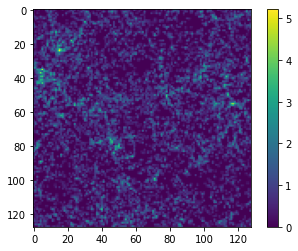

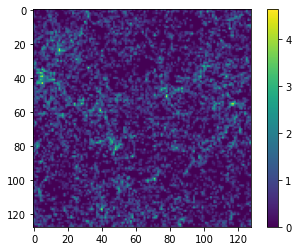

sats


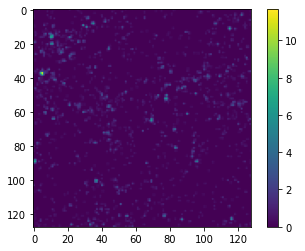

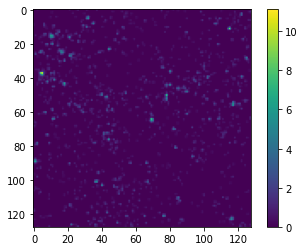

In [7]:
print("centrals")
imshow(np.array(painted_central_tf[0]).sum(axis=0))
colorbar()
show()

imshow(np.array(painted_central_hod[0]).sum(axis=0))
colorbar()
show()
print("sats")

imshow(np.array(painted_sat_tf[0]).sum(axis=0))
colorbar()
show()

imshow(np.array(painted_sat_hod[0]).sum(axis=0))
colorbar()
show()

In [8]:
from diffhod.mock_observables.pk import Power_Spectrum

In [9]:
pk = Power_Spectrum([128,128,128],[128,128,128], 0.01, 0.2)

In [10]:
karray, pkarray = pk.pk_tf(painted_sat_hod+painted_central_hod)
karray_tf, pkarray_tf = pk.pk_tf(painted_sat_tf+painted_central_tf)

Instructions for updating:
Use fn_output_signature instead


Text(0.5, 0, 'k')

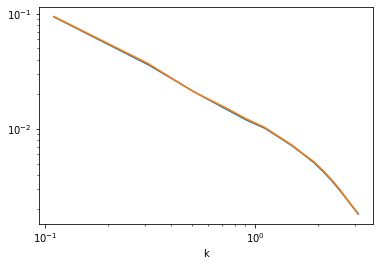

In [11]:
plt.loglog(karray, pkarray[0])
plt.loglog(karray_tf, pkarray_tf[0])
plt.xlabel(r"k")

In [12]:
#very inefficient loop! should be done easier since things are batch capable, but too lazy to debug...
pk_tf_array = []
pk_hod_array = []

pk_tf_array_sat = []
pk_hod_array_sat = []

pk_tf_array_cen = []
pk_hod_array_cen = []

samples = 500

for samp in range(0,samples):
    print(samp)
    # Sample DHOD
    gal_cat = helper_hod(tf_halocat)
    # Same thing with halotools
    zheng07_model.populate_mock(halocat) 
    
    
    bs = 128
    #DHOD selected
    sample1 = gal_cat['pos_cen']/128*bs
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[1,1,1])

    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3])/128*bs
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[1,1,1])

    #HOD selected

    # Let's define halotools samples
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                           zheng07_model.mock.galaxy_table['y'],
                                           zheng07_model.mock.galaxy_table['z'])
    m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001

    #cutting same subvolume
    ht_cens = ht_sample[m]
    ht_cens = ht_cens[ht_cens[:,0]<128] 
    ht_cens = ht_cens[ht_cens[:,1]<128] 
    ht_cens = ht_cens[ht_cens[:,2]<128] 

    ht_sats = ht_sample[~m]
    ht_sats = ht_sats[ht_sats[:,0]<128] 
    ht_sats = ht_sats[ht_sats[:,1]<128] 
    ht_sats = ht_sats[ht_sats[:,2]<128] 

    #DHOD painted
    painted_central_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample1_r,weight=gal_cat['n_cen'])
    painted_sat_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample2_r,weight=tf.reshape(gal_cat['n_sat'], [-1,]))

    #hod painted
    painted_central_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_cens.reshape(1,-1,3)/128*bs)
    painted_sat_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sats.reshape(1,-1,3)/128*bs)
    
    
    karray, pkarray = pk.pk_tf(painted_sat_hod+painted_central_hod)
    karray_tf, pkarray_tf = pk.pk_tf(painted_sat_tf+painted_central_tf)
    
    pk_tf_array.append(pkarray_tf[0])
    pk_hod_array.append(pkarray[0])
    
        
    karray, pkarray = pk.pk_tf(painted_sat_hod)
    karray_tf, pkarray_tf = pk.pk_tf(painted_sat_tf)
    
    pk_tf_array_sat.append(pkarray_tf[0])
    pk_hod_array_sat.append(pkarray[0])
    
        
    karray, pkarray = pk.pk_tf(painted_central_hod)
    karray_tf, pkarray_tf = pk.pk_tf(painted_central_tf)
    
    pk_tf_array_cen.append(pkarray_tf[0])
    pk_hod_array_cen.append(pkarray[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
avg_all = np.mean(np.array(pk_hod_array),axis=0)
avg_cen = np.mean(np.array(pk_hod_array_cen),axis=0)
avg_sat = np.mean(np.array(pk_hod_array_sat),axis=0)

In [14]:
std_all = np.std(np.array(pk_hod_array),axis=0)
std_cen = np.std(np.array(pk_hod_array_cen),axis=0)
std_sat = np.std(np.array(pk_hod_array_sat),axis=0)

In [15]:
avg_all_tf = np.mean(np.array(pk_tf_array),axis=0)
avg_cen_tf = np.mean(np.array(pk_tf_array_cen),axis=0)
avg_sat_tf = np.mean(np.array(pk_tf_array_sat),axis=0)

std_all_tf = np.std(np.array(pk_tf_array),axis=0)
std_cen_tf = np.std(np.array(pk_tf_array_cen),axis=0)
std_sat_tf = np.std(np.array(pk_tf_array_sat),axis=0)

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

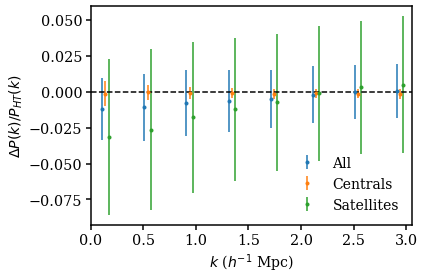

In [17]:
plt.errorbar(karray[::2],(avg_all[::2]-avg_all_tf[::2])/avg_all_tf[::2],yerr=std_all_tf[::2]/avg_all_tf[::2],fmt='.',label="All")
plt.errorbar(karray[::2]+0.03,(avg_cen[::2]-avg_cen_tf[::2])/avg_cen_tf[::2],yerr=std_cen_tf[::2]/avg_all_tf[::2],fmt='.',label="Centrals")
plt.errorbar(karray[::2]+0.06,(avg_sat[::2]-avg_sat_tf[::2])/avg_sat_tf[::2],yerr=std_sat_tf[::2]/avg_sat_tf[::2],fmt='.',label="Satellites")
plt.ylabel("$\Delta P(k)/P_{HT}(k)$",fontsize=14)
plt.xlabel("$k$ ($h^{-1}$ Mpc)",fontsize=14)

plt.plot([0,karray[-1]+0.06],[0,0], "k--")

plt.xlim(0,3.05)
legend(loc=4,fontsize=14)

tight_layout()
plt.savefig("ps_error.pdf")